In [1]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [3]:
# parameters
freq = 100
dt = 1/freq
time = np.linspace(0, 100, int(100/dt)+1)
num_imus = 6
angvel_magnitude = 1
num_steps = 360 / (dt * angvel_magnitude) + 1 # dt [s] * angvel_magnitude [deg/s] * num [] = 360 [deg]

rng = np.random.default_rng(2021)

WN = 1.0e-6 #*np.ones((3,num_imus))  # standard deviation
RRW = 1.0e-6 #*np.ones((3,num_imus))   # standard deviation
input_noise = 1.0e-12 # Input angular acceleration standard deviation

In [4]:
def dynamics(t, dt, state, RRW, input_noise, num_imus):
	rng = np.random.default_rng()
	state_next = np.zeros(6)
	state_next[0:3] = state[0:3] + state[3:6]*dt # omega
	state_next[3:6] = rng.normal(loc=0, scale=input_noise, size=3) # omega_dot
	state_next[6:6+3*num_imus+1] = state[6:6+3*num_imus+1] + rng.normal(loc=0, scale=RRW, size=6+num_imus)
	
	return state_next

In [5]:
def measurement(state, WN, num_imus):
	meas = np.zeros(3*num_imus)
	Rb_si = np.eye(3)
	for i in range(0, num_imus-1):
		omega = state[0:3]
		RRW_sub = state[i*3+6:i*3+9]
		meas[i*3:i*3+3] = Rb_si*omega + rng.normal(loc=0, scale=WN, size=3) + RRW_sub
	
	return meas

In [6]:
rng = np.random.default_rng()

# Define system dynamics
state_true = np.zeros(6+3*num_imus) # omega, omegadot, RRW DB1, ...
# state[0] = state[1] = state[2] = 1
state = np.zeros(6+3*num_imus)
state_hist = np.zeros([6+3*num_imus, len(time)])
P = 1.0e-4*np.eye(6+3*num_imus) # initial covariance
A = np.eye(6+3*num_imus)
A[0,3] = A[1,4] = A[2,5] = dt
A[3,3] = A[4,4] = A[5,5] = 0

B = np.zeros(6+3*num_imus)
B[3:6] = rng.normal(loc=0, scale=input_noise, size=3)
B[6:6+3*num_imus+1] = rng.normal(loc=0, scale=RRW, size=3*num_imus)
B.reshape(6+3*num_imus,1)

# Process noise covariance matrix
Q = np.zeros([6+3*num_imus, 6+3*num_imus])
Q[3:6, 3:6] = np.eye(3) * input_noise**2
Q[6:6+3*num_imus+1, 6:6+3*num_imus+1] = RRW**2*np.eye(3*num_imus)

# Define measurment equation
meas = np.zeros([3*num_imus])
meas_hist = np.zeros([3*num_imus, len(time)])
H = np.zeros((3*num_imus, 6+3*num_imus))
for j in range(0, num_imus):
	H[j*3:j*3+3, 0:3] = np.eye(3)

# Measurement noise covariance matrix
R = WN**2 * np.eye(3*num_imus)

for i in range(1,len(time)):
	state = np.dot(A, state) + B
	for j in range(0, num_imus):
		meas[j*3:j*3+3] = state[0:3] + state[6+j*3:6+j*3+3] + rng.normal(loc=0, scale=WN, size=3)
	
	#Update Kalman filter
	K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T) + R))
	state = state + np.dot(K, (meas - np.dot(H, state)))
	P = np.dot((np.eye(6+3*num_imus)-np.dot(K, H)), P)

	state_hist[:,i] = state
	meas_hist[:,i]  = meas

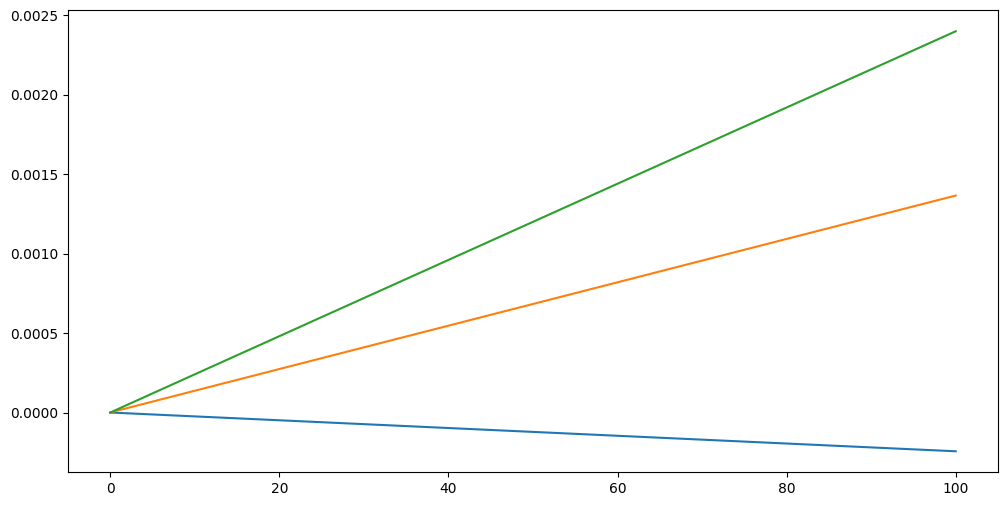

In [7]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[0,:])
plt.plot(time, state_hist[1,:])
plt.plot(time, state_hist[2,:])
# plt.plot(time, meas_hist[9,:])
# plt.plot(time, meas_hist[10,:])
# plt.plot(time, meas_hist[11,:])
